<a href="https://colab.research.google.com/github/avranasa/Coded-ResNeXt/blob/main/Coded_ResNeXt_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#We had troubles on running with Colab TPU accelarator and different version of pytorch.
#If prompted/printed after running this cell, press the button to RESTART RUNTIME 
!pip install timm
!apt-get install -q subversion
!svn checkout https://github.com/avranasa/Coded-ResNeXt.git/trunk/CIFAR /content/CIFAR
!pip uninstall -y torch
!pip install torch==1.8.2+cpu  torchvision==0.9.2+cpu -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
!pip install -q cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl
!pip install -q pytorch-lightning
!pip install -q torchtext==0.9.1 -f https://download.pytorch.org/whl/cu101/torch_stable.html

In [2]:
import pytorch_lightning as pl
import os, sys, timm
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
sys.path.insert(0, '/content/CIFAR') 
from NN_ResNeXt import Net_ResNext, DataModule
from NN_modules import ResNeXt_block

'''
For the architectures described below the notation is the following:
    -'conv3_in3_out64': a convolution layer with kernel_size (3,3) input's number of channels is 3 and output's is 64
    -'avgPool8': an average pool with kernel_size (8,8)
    -'linear_in1024': the last linear has the number output features equal to the number of classes and input equal to 1024
    - A Coded-ResNeXt block is described as: 
      [Number_of_Input_Channels, Number_of_Output_Channels, Bottleneck_width, Stride_Of_the_second_convolutional_layer, Coding_scheme_ration, Probability_dropSubNN ]'
'''


d = 11 #Bottleneck_width of first stage
dp_prob = 0.1
ARCHITECTURE_CIFAR_10 = [#stem. Resolution (32x32)
                        'conv3_in3_out64', 'bn2D_in64', 'relu',
                        #stage 1
                        [ 64, 256, d, 1, '10/10', 0.0 ], #Index Of Block: 0,  Resolution (32x32)
                        [ 256, 256, d, 1, '10/10', 0.0 ],
                        [ 256, 256, d, 1, '10/10', 0.0 ],                         
                        #stage 2
                        [ 256, 512, 2*d, 2, '5/10' , dp_prob ], #Index Of Block: 3,  Resolution (16x16)
                        [ 512, 512, 2*d, 1, '5/10' , dp_prob ], 
                        [ 512, 512, 2*d, 1, '5/10' , dp_prob ], 
                        #stage 3
                        [ 512, 1024, 4*d, 2, '3/10', dp_prob ], #Index Of Block: 6,  Resolution (8x8)
                        [ 1024, 1024, 4*d, 1, '3/10', dp_prob ], 
                        [ 1024, 1024, 4*d, 1, '3/10', dp_prob ],          
                        #Last layers
                        'avgPool8', 'flatten','linear_in1024' 
                        ]

d=6 
dp_prob = 0.1 
ARCHITECTURE_CIFAR_100 = [ #stem
                        'conv3_in3_out64', 'bn2D_in64', 'relu',
                        #stage 1
                        [ 64, 256, d, 1, '20/20', 0.0 ], #Index Of Block: 0,  Resolution (32x32)
                        [ 256, 256, d, 1, '20/20',0.0 ],
                        [ 256, 256, d, 1, '20/20',0.0 ],                         
                        #stage 2
                        [ 256, 512, 2*d, 2, '8/20',dp_prob ], #Index Of Block: 3,  Resolution (16x16)
                        [ 512, 512, 2*d, 1, '8/20',dp_prob ],  
                        [ 512, 512, 2*d, 1, '8/20',dp_prob ],  
                        #stage 3
                        [ 512, 1024, 4*d, 2, '4/20',dp_prob ], #Index Of Block: 6,  Resolution (16x16)
                        [ 1024, 1024, 4*d, 1, '4/20',dp_prob ],  
                        [ 1024, 1024, 4*d, 1, '4/20',dp_prob ],             
                        #Last layers
                        'avgPool8', 'flatten','linear_in1024' 
                        ]

In [3]:
ARGS = {
        #~~~~~~Problem's settings~~~~~~
        'Problem': 'Cifar10',#Choose between: 'Cifar10', 'Cifar100'  
        'Control': False, #If True then the original ResNeXt is trained.

        #~~~~~~Architectural & interpretability choices~~~~~~
        'Energy_normalization': True,
        'Same_code_Same_mask': True, #If True then two consecutive ResNeXt blocks that have the same coding scheme will
                                #also have the same dropout mask applied to them. Therefore out of N consecutive ResNeXt blocks
                                #with the same coding scheme it will be the first one dropSubNN_probability that counts.
   
        #~~~~~~Losses choices~~~~~~
        'LossDisentangle_type':'power4_threshold0.0', #Loss = diff(E_subNN, target_Energy, threshold)^power.
                                            #The diff function is: max{ |Energy_subNN-target_Energy|-threshold, 0}
        'LossDisentanglement_coef': 4, #Coefficient the loss_disentangle is multiplied with (Denoted $\mu$ in the paper)
                                     #Generally it doesn't affect the overall performance but improves the binary classifiers.
        
        #~~~~~~RandAugment~~~~~~
        'no-augmentation': False, #If true then no data augmentation will be used
        'timm-AutoAugment': 'rand-m2-n1',#The notation is from "https://fastai.github.io/timmdocs/RandAugment"
                                         #For CIFAR100:'rand-m2-n1' and for CIFAR10 'rand-m4-n3'
            
        #~~~~~~Optimization's algorithm choices~~~~~~
        'train_batchSize': 64,#1 step in 8 core training is computing 8 gradients and syncing them, so effectively the size is 8*64=512
        'test_batchSize': 64,
        'N_epochs': 300, 
        'SGD_lr_momentum': [0.1, 0.9, 5e-4, True],#(initial_lr, momentum, weight decay, Nesterov)
        'N_workers_dataloader': 4,
        }

ARGS['architecture'] =  ARCHITECTURE_CIFAR_10 if ARGS['Problem']=='Cifar10' else ARCHITECTURE_CIFAR_100

In [ ]:
#Also consider using your google drive to save "permanently" the checkpoints
!mkdir /content/checkpoints
SAVING_PATH_CHECKPOINTS = "/content/checkpoints/"
NAME_EXPERIMENT = "new_exp"

checkpoint_callback = ModelCheckpoint(every_n_epochs=10, filename=NAME_EXPERIMENT, dirpath=SAVING_PATH_CHECKPOINTS)
dm = DataModule(ARGS)
my_model = Net_ResNext(ARGS)
trainer = Trainer( max_epochs=ARGS['N_epochs'], num_sanity_val_steps=0, tpu_cores=8, precision='bf16', callbacks=[checkpoint_callback])

#In the progress bar the validation accuracy also appears
#The training/validation losses/accuracies and the accuracy of the early decoders are logged in case it is desired to 
#use the Tensorboard to plot those figures.
trainer.fit(my_model, dm)

--> Using rand augment with:  rand-m2-n1


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar-100-python.tar.gz to ./
Files already downloaded and verified
For class 0



Forward passes for the loader:   train
The metric which it tried to maximize:  F1-score
and the threshold found was: 3.013
F1-score : 87.796%
Precision : 89.352%
Recall : 86.295%
BalancedAcc : 92.576%

Forward passes for the loader:   test
The metric which it tried to maximize:  F1-score
and the threshold found was: 3.652
F1-score : 87.551%
Precision : 88.627%
Recall : 86.500%
BalancedAcc : 92.633%
Precision and recall for optimal threshold ( 0.8863, 0.8650)
Precision and recall using threshold estimated from training dataset ( 0.8261, 0.9170)

Forward passes for the loader:   out_of_distr
----USING OUT OF DISTRIBUTION NEGATIVES----
Precision and recall using threshold estimated from training dataset ( 0.5859, 0.9170)


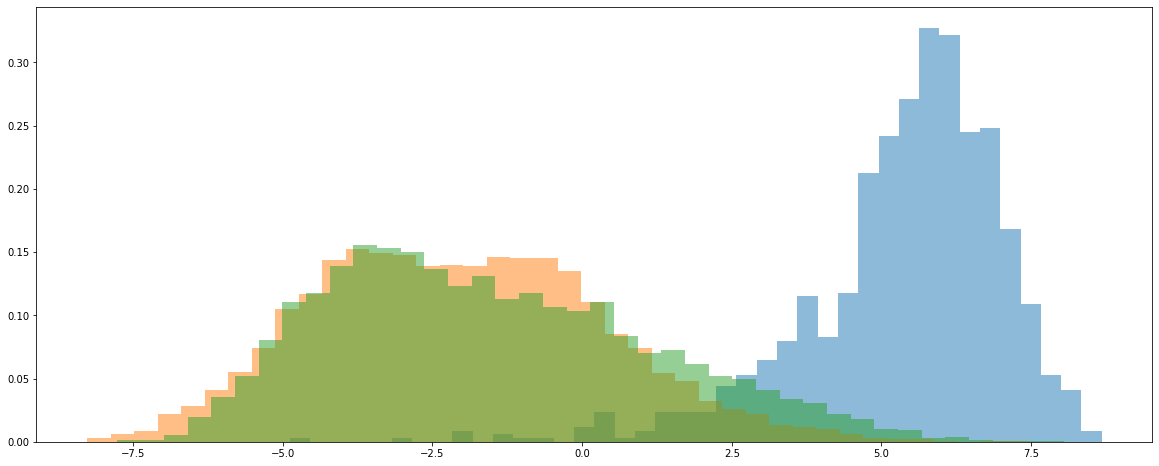

In [5]:
'''
After training the model  from InterpretabilityFunctions.py there are two functions to test 
the specialization of the subNNs. The first one is:
  -test_print_acc_removing_subNNs(indx_block, List_N_subNNs_to_remove, model, device, test_loader):
        Given the index of the block (equal to $l-1$ in reference to the paper as in the paper the indexing 
        started from 1 and here from 0) and a list indicating how many subNNs to remove (for example [2,4] will
        do two experiments one removing 2 subNNs and one removing 4) and runs the experiment where 
        from the given block it removes with the two different ways subNNs.
  -test_partNN_asBinaryClassifier(model, device,  class_of_model_part, test_loader, train_loader=None, out_of_distr_loader=None):
        It tests and prints the performance of the binary classifier for the class "class_of_model_part". 
        Also plots the distribution of the positive, negative and out of distribution samples. It returns for that binary classifier
        its output for all positive, negative and out of distribution samples.
An example:
'''
from InterpretabilityFunctions import test_partNN_asBinaryClassifier
import torch_xla.core.xla_model as xm
import copy
device = xm.xla_device()
copied_model = Net_ResNext(ARGS)
copied_model.load_state_dict(my_model.state_dict())
copied_model.to(device)

ARGS_OUF_OF_DISTR = copy.deepcopy(ARGS)
ARGS_OUF_OF_DISTR['Problem'] = 'Cifar100'
dmOutOfDistr = DataModule(ARGS_OUF_OF_DISTR)
dmOutOfDistr.prepare_data()
dmOutOfDistr.setup()

cl = 0 #binary classifier for the first class
res = test_partNN_asBinaryClassifier(copied_model, device, cl, dm.val_dataloader(), dm.train_dataloader(),dmOutOfDistr.val_dataloader())
